# Example on EDM dataset
This notebook shows how to go from the EELS data to elemental maps using the model-based approach. This approach uses both the contrained linear background and contrained fine structure. 

In [1]:
#to enable interadtive plots in a separate window, needed for some plotting features
%matplotlib qt

In [2]:
import matplotlib.pyplot as plt
import pyEELSMODEL.api as em

from pyEELSMODEL.components.linear_background import LinearBG
from pyEELSMODEL.components.gdoslin import GDOSLin
from pyEELSMODEL.components.constrained_gdoslin import ConstrainedGDOSLin
from pyEELSMODEL.components.MScatter.mscatterfft import MscatterFFT

In [3]:
#specify the filename of the EMD file
filename = r"D:\emd_test\STEM_EELS_1.emd"


#### Loading of the data
s is a list of multispectra depending on how many are acquired. Additionaly, the metadata contains the acceleration voltage (E0) and collection angle (beta) which are needed for the quantification. The images is a list containing the other scanned images acquired simultaneously

In [4]:
# Load multi-spectrum data
s, E0, beta = em.MultiSpectrum.load(filename)

The number of frames in the scan images is: 1
Found 2 EELS spectrum images
Cube: 079119e9d86a410991f94ba6982639d8, shape:(128, 2048, 128)
Cube: 7e95a82a59f340fd9eaf5089ba11a863, shape:(128, 2048, 128)


In [5]:
em.MultiSpectrumVisualizer(s)

c:\users\daen.jannis1\documents\pyeelsmodel\pyEELSMODEL\operators\multispectrumvisualizer.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


In [7]:
for spec in s:
    print(f"Dispersion: {spec.dispersion} eV/channel, Energy offset: {spec.offset} eV")
print(f"Acceleration voltage: {E0} V")
print(f"Collection angle: {beta*1e3} mrad")

Dispersion: 1 eV/channel, Energy offset: -100 eV
Dispersion: 1 eV/channel, Energy offset: 300 eV
Acceleration voltage: 300000 V
Collection angle: 42.864383598524284 mrad


#### Alignment using the zero-loss
The low loss is the first index of the list containing the multispectrum in this case. In this particular dataset, no zero loss shift is measured.  

In [8]:
align = em.FastAlignZeroLoss(s[0], s[1:])

In [9]:
align.perform_alignment()

dataset is already aligned


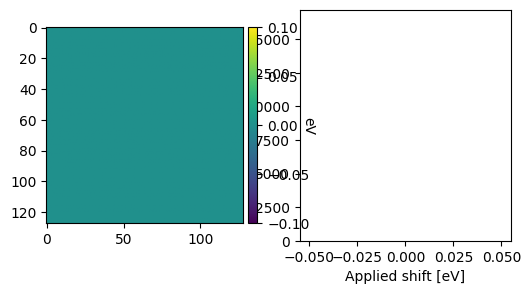

In [10]:
align.show_alignment_result()
align.show_shift()

#### Elemental mapping

In [19]:
sig = align.aligned_others[0]
ll = align.aligned

In [20]:
from pyEELSMODEL.operators.quantification.elemental_quantification import ElementalQuantification

In [21]:
alpha = 21e-3 #convergence angle in radians
settings = [E0, alpha, beta]

elements = ['Sc', 'O', 'Dy']
edges = ['L', 'K', 'M']
onsets = [-5, -3, -10]

intervals = [100, 100, 300] #the region over which you expect fine structure

##### Single spectrum 
The single spectrum can be used to optimize some hyperparameters which in this case are the edge onsets and the intervals. 
1. onsets: list of adjustments to the literature values of the edge onsets in eV.
2. intervals: list of interval over which the fine structure should be added in eV. For the constrains to hold one should choose a big enough window.  

In [22]:
single_quant = ElementalQuantification(sig.mean(), elements, edges, settings, ll.mean())
single_quant.onsets = onsets
single_quant.use_fine = True
single_quant.fine_intervals = intervals

In [23]:
single_quant.do_procedure()


cannot use analytical gradients since a convolutor is inside model


Using convexity constrains for linear background
Convergent incoming beam is used
convergence angle is: 0.021
collection angle is: 0.042864383598524285
Convergent incoming beam is used
convergence angle is: 0.021
collection angle is: 0.042864383598524285
Convergent incoming beam is used
convergence angle is: 0.021
collection angle is: 0.042864383598524285
Using quadratic fitter to use constraints


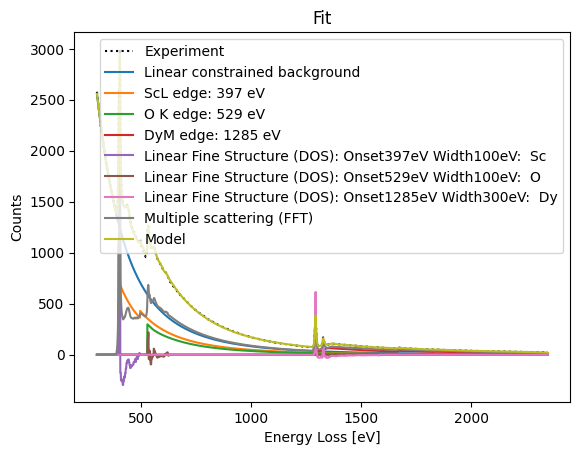

In [24]:
single_quant.fitter.plot()

The visualization gives an idea if the chosen parameters are good. Escpecially the fine structure regions should be large enough but not overlap with other edges. For the onset, the edge should start appearing when experimental edge appears

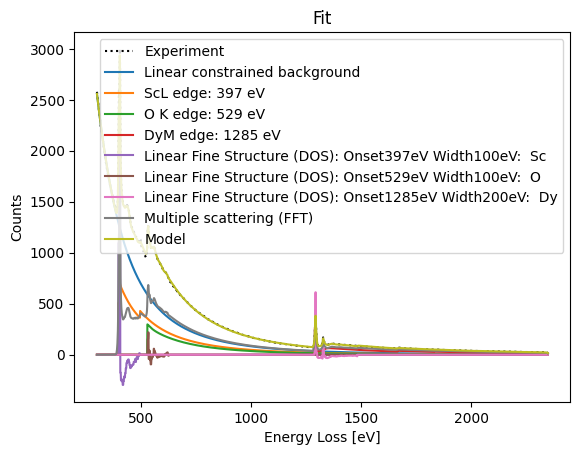

In [17]:
# visualization of the fit on the average spectrum
single_quant.fitter.plot()


##### Multispectrum fit: No fine structure
A fast elemental map which does not use the fine structure. Can be used to get faster feedback but has a larger bias in certain cases. 

In [25]:
quant = ElementalQuantification(sig, elements, edges, settings, ll)
quant.onsets = onsets
quant.use_fine = False
quant.fine_intervals = intervals


In [26]:
quant.do_procedure()

cannot use analytical gradients since a convolutor is inside model


Using convexity constrains for linear background
Using quadratic fitter to use constraints


100%|██████████| 16384/16384 [00:07<00:00, 2136.99it/s]


##### Multispectrum: Adding constrained fine structure
The last quantification is the most accurate and precise but lacks speed. So fitting procedure can take a couple of minutes. 

In [27]:
quant_fine = ElementalQuantification(sig, elements, edges, settings, ll)
quant_fine.onsets = onsets
quant_fine.use_fine = True
quant_fine.fine_intervals = intervals

In [28]:
quant_fine.do_procedure()

cannot use analytical gradients since a convolutor is inside model


Using convexity constrains for linear background
Convergent incoming beam is used
convergence angle is: 0.021
collection angle is: 0.042864383598524285
Convergent incoming beam is used
convergence angle is: 0.021
collection angle is: 0.042864383598524285
Convergent incoming beam is used
convergence angle is: 0.021
collection angle is: 0.042864383598524285
Using quadratic fitter to use constraints


100%|██████████| 16384/16384 [00:24<00:00, 673.57it/s]
